In [1]:
from astropy.io import fits
import pandas as pd
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.vq import vq, kmeans
import scipy
from astroquery.gaia import Gaia
import os

In [2]:
def read_des_fits(file_path, band, n = int(1e6)):
    # Read in the fits file and close it
    hdul = fits.open(file_path)
    
    # hdul[1].data is a numpy recarray. Get the ra, dec, mag and band columns   
    cols = ['ra', 'dec', 'mag', 'band']
    zidx = np.random.choice(np.where(hdul[1].data['band'] == band)[0], size = n, replace = False)
    data = {col: hdul[1].data[col][zidx] for col in cols}
    hdul.close()

    des = pd.DataFrame(data)
    

    # Combine ra and dec into a sky coord array
    des['coord'] = SkyCoord(ra=des['ra'], dec=des['dec'], unit = 'deg')
    return des

# Read in the DES data
BAND = 'i'
PSF_DATA_FILEPATH = "../../psf_data/psf_y3a1-v29.fits"
TOTAL_SUBSAMPLE_SIZE = 1000000
des = read_des_fits(PSF_DATA_FILEPATH, BAND, n = TOTAL_SUBSAMPLE_SIZE)


In [3]:
# Print max and min of magnitude column
des['mag'].max(), des['mag'].min()

(20.999996185302734, 15.385494232177734)

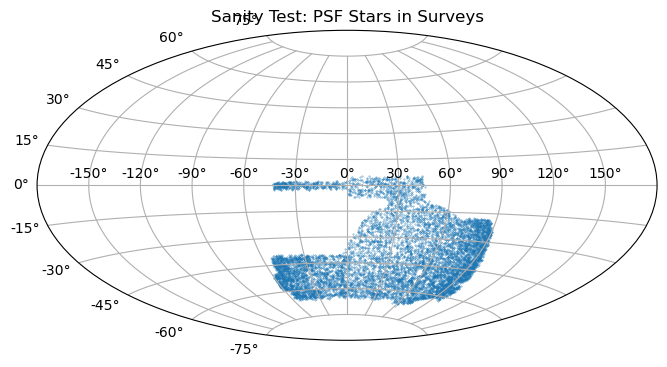

In [4]:
# Function to plot the ra and dec of the PSF stars
def plot_sanity_test(coord, n = 10000):
    plt.figure(figsize=(8,4.2))
    plt.subplot(111, projection="aitoff")
    plt.title("Sanity Test: PSF Stars in Surveys")
    plt.grid(True)
    
    # Choose n random stars
    coord = coord.sample(n=n)
    
    ra_rad = np.array([c.ra.wrap_at(180 * u.deg).radian for c in coord])
    dec_rad = np.array([c.dec.radian for c in coord])
    plt.scatter(ra_rad, dec_rad, s=0.1, alpha=0.8)
    plt.show()
    
# Plot the ra and dec of the PSF stars
plot_sanity_test(des['coord'])


In [11]:
CLUSTER_SUBSAMPLE_SIZE = 10000
NUMBER_OF_CLUSTERS = 200

# Get 2D array of ra and dec from dataframe
ra_dec = np.array([des['ra'], des['dec']]).T
ridx = np.random.choice(np.arange(ra_dec.shape[0]), size = CLUSTER_SUBSAMPLE_SIZE, replace = False)
ra_dec_sample = ra_dec[ridx]

# Perform clustering on subsample
cents = kmeans(ra_dec_sample, NUMBER_OF_CLUSTERS)
print("Centroids found.")
centroids = cents[0]
cluster_num_array = vq(ra_dec, centroids)
print("Stars clustered.")

# Generate cluster info df
max_dist_pts = {i:[np.array([k for k in cluster_num_array[1][cluster_num_array[0] == i]]).max()] for i in range(NUMBER_OF_CLUSTERS)}
cluster_info = pd.DataFrame(max_dist_pts).T
cluster_info.columns = ["max_dist"]
cluster_info["clusterno"] = cluster_info.index
cluster_info["centroids"] = list(centroids)

Centroids found.
Stars clustered.


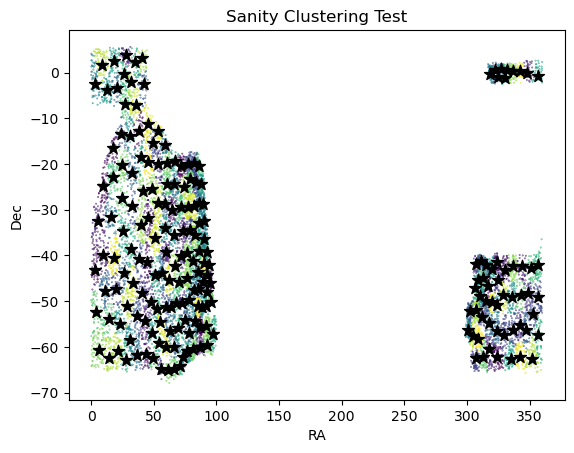

In [12]:
# Sanity check: plot clustering result
def plot_cluster_test(ra_dec, centroids, cluster_num_array):
    
    # Sample 10000 random 2D points from numpy array
    idx = np.random.choice(ra_dec.shape[0], 10000, replace=False)
    rds = ra_dec[idx, :]
    
    # scatter plot of K-Means cluster
    plt.scatter(rds[:, 0],
                rds[:, 1],
                c=cluster_num_array[0][idx], s  = 0.1)
    
    # Centroid of the clusters
    plt.scatter(centroids[:, 0],
                centroids[:, 1],
                marker='*',
                s=80,
                color='black')

    plt.title("Sanity Clustering Test")
    plt.xlabel("RA")
    plt.ylabel("Dec")
    
# plot cluster test
plot_cluster_test(ra_dec, cents[0], cluster_num_array)

In [13]:
def query_gaia_for_cluster_old(ra, dec, dist):
    # Define the center coordinates of your region and the search radius
    center_coordinates = SkyCoord(ra=ra, dec=dec, unit=(u.degree, u.degree))
    search_radius = dist * u.deg  # Adjust the radius as needed
    
    Gaia.ROW_LIMIT = -1
    job = Gaia.cone_search_async(center_coordinates, radius=search_radius, columns=["ra", "dec"])
    result_table = job.get_results()
    gaia_table = result_table.to_pandas()
    
    return gaia_table

In [14]:
def query_gaia_for_cluster(ra, dec, dist, lim = 1e6, verbose = False):
    # Define the center coordinates of your region and the search radius
    center_coordinates = SkyCoord(ra=ra, dec=dec, unit=(u.degree, u.degree))
    search_radius = dist * u.deg  # Adjust the radius as needed
    
    Q = """
    select top {limit} ra, dec, phot_g_mean_mag, in_qso_candidates, in_galaxy_candidates, non_single_star, astrometric_excess_noise
    FROM gaiadr3.gaia_source
    WHERE 1 = CONTAINS(
    POINT({ra}, {dec}),
    CIRCLE(ra, dec, {radius}))
    order by source_id
    """

    Gaia.ROW_LIMIT = -1
    query = Q.format(ra=ra,dec=dec,radius=search_radius.value, limit = int(lim))
    if verbose:
        print(query)
    job = Gaia.launch_job(query, dump_to_file=True)
    result_table = job.get_results()
    gaia_table = result_table.to_pandas()
    
    # Alex DW Recommended Star-Galaxy Cut. Objects which pass this cut are stars, otherwise, galaxy.
    
    gaia_table["is_star"] = (np.log10(np.maximum(gaia_table['astrometric_excess_noise'], 1e-12)) < np.maximum((gaia_table['phot_g_mean_mag']-18.2)*.3+.2,.3))
    gaia_table.drop(columns=['astrometric_excess_noise', 'phot_g_mean_mag'], inplace=True)
    
    if len(gaia_table) == lim:
        print(f"Warning: Limit of {lim} reached. Increase limit or decrease radius (increase number of clusters).")
    
    return gaia_table

In [15]:
def match_cluster_to_gaia(cluster_num_array, ra_dec, cluster_info, cluster_num):
    """
    Match stars in cluster 'cluster_num' to gaia stars. Create a table with gaia coords, cluster coords, and flag for matched stars.
    """
    
    # Query gaia and match stars to cluster    
    clust0_info = cluster_info.loc[cluster_num]
    print("R = {:.3f}".format(clust0_info["max_dist"]), end = ' | ')
    gaia0_tab = query_gaia_for_cluster(clust0_info["centroids"][0], clust0_info["centroids"][1], clust0_info["max_dist"])
    
    print("Queried.", end = ' ')
    
    cluster0 = SkyCoord(ra_dec[cluster_num_array[0] == cluster_num] * u.deg)
    mag0 = np.array(des['mag'][cluster_num_array[0] == cluster_num])
    gaia0 = SkyCoord(ra = gaia0_tab['ra'], dec = gaia0_tab['dec'], unit=u.deg)
    idx_clust, sep2d_clust, _ = cluster0.match_to_catalog_sky(gaia0)
    
    # Create table with gaia0 coords, cluster0 coords, and flag for matched stars
    comb_stars = pd.DataFrame({'matched': np.zeros(len(cluster0))})
    comb_stars.loc[sep2d_clust < MATCH_LIM] = 1
    comb_stars['sep2d'] = sep2d_clust.arcsec # in arcsec
    comb_stars['mag0'] = mag0
    comb_stars['is_star'] = np.array(gaia0_tab['is_star'].iloc[idx_clust])
    comb_stars['in_qso_candidates'] = np.array(gaia0_tab['in_qso_candidates'].iloc[idx_clust])
    comb_stars['in_galaxy_candidates'] = np.array(gaia0_tab['in_galaxy_candidates'].iloc[idx_clust])
    comb_stars['non_single_star'] = np.array(gaia0_tab['non_single_star'].iloc[idx_clust])

    get_ra = lambda x: x.ra.degree
    get_dec = lambda x: x.dec.degree

    comb_stars["gaia_ra"] = gaia0[idx_clust].ra.degree
    comb_stars["gaia_dec"] = gaia0[idx_clust].dec.degree
    comb_stars["cluster_ra"] = cluster0.ra.degree
    comb_stars["cluster_dec"] = cluster0.dec.degree
    
    return comb_stars

In [16]:
MATCH_LIM = 1 * u.arcsec
INT_DATA_PATH = "../../int_data/idata/"

# Combine pandas dataframes from all clusters
master_comb_df = pd.DataFrame()
for i in range(NUMBER_OF_CLUSTERS):
    print("Cluster " + str(i) + ":", end = ' ')
    comb_clusteri = match_cluster_to_gaia(cluster_num_array, ra_dec, cluster_info, i)
    print("Matched.")
    comb_clusteri.to_csv(INT_DATA_PATH + "cluster_" + str(BAND) + "_" + str(i) + ".csv")
    master_comb_df = pd.concat([master_comb_df, comb_clusteri])

Cluster 0: R = 3.858 | 

Queried. Matched.
Cluster 1: R = 3.569 | Queried. Matched.
Cluster 2: R = 6.579 | Queried. Matched.
Cluster 3: R = 3.737 | Queried. Matched.
Cluster 4: R = 5.853 | 

AttributeError: 'str' object has no attribute 'read'

Text(0.5, 1.0, 'Matched Stars: Separation in Arcsec')

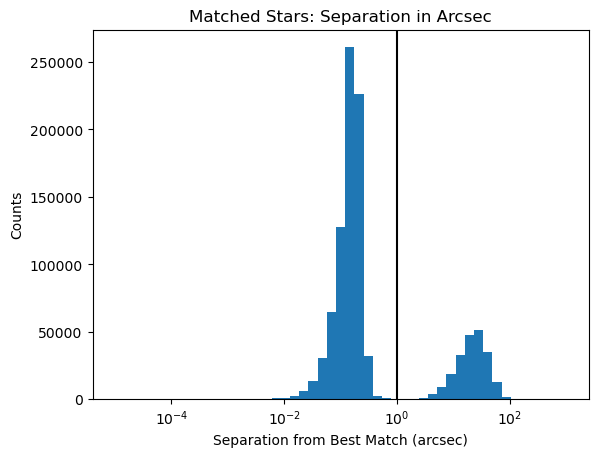

In [30]:
def sanity_separation_test(master_comb_df):
    plt.hist(master_comb_df["sep2d"], bins = np.logspace(-5, 3))
    plt.semilogx()
    plt.axvline(1, color = "k")
    plt.ylabel("Counts")
    plt.xlabel("Separation from Best Match (arcsec)")
    plt.title("Matched Stars: Separation in Arcsec")
    return

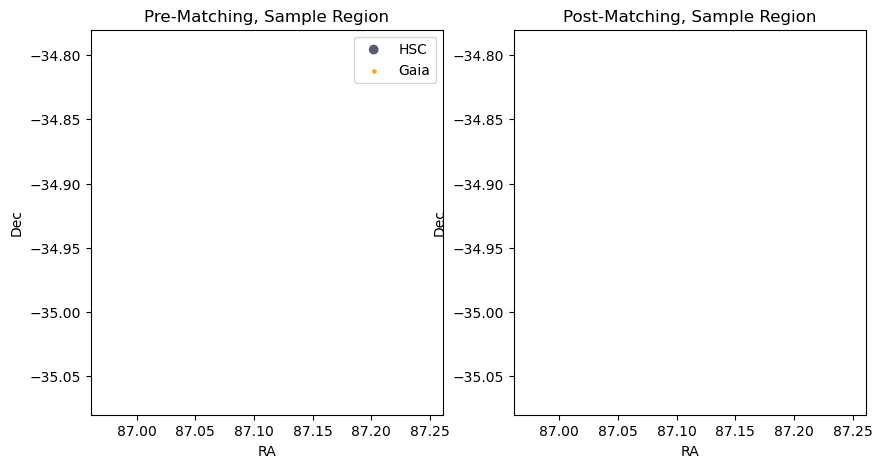

In [31]:
def sanity_crossmatch_test(master_comb_df, i = 0):

    fig, ax = plt.subplots(1, 2, figsize = (10, 5))


    # Scatter plot for the first subplot
    ax[0].scatter(master_comb_df["cluster_ra"], master_comb_df["cluster_dec"], c = master_comb_df["mag0"], cmap = "cividis", 
                vmin = 18, vmax = 23, label = "HSC")
    ax[0].scatter(master_comb_df["gaia_ra"], master_comb_df["gaia_dec"], s=5, color="orange", label = "Gaia")
    ax[0].legend(loc = 'upper right')

    # Set labels and limits for the first subplot
    ax[0].set_xlabel("RA")
    ax[0].set_ylabel("Dec")
    ax[0].set_xlim(centroids[i][0] - 0.15, centroids[i][0] + 0.15)
    ax[0].set_ylim(centroids[i][1] - 0.15, centroids[i][1] + 0.15)

    ax[0].set_title("Pre-Matching, Sample Region")

    # Scatter plot for the second subplot
    match_idx = (master_comb_df["matched"] == 1)
    ax[1].scatter(master_comb_df["cluster_ra"][match_idx], master_comb_df["cluster_dec"][match_idx], c = master_comb_df["mag0"][match_idx], cmap = "cividis",
                vmin = 18, vmax = 23)
    ax[1].scatter(master_comb_df["gaia_ra"][match_idx], master_comb_df["gaia_dec"][match_idx], s=5, color="orange")

    # Set labels and limits for the second subplot
    ax[1].set_xlabel("RA")
    ax[1].set_ylabel("Dec")
    ax[1].set_xlim(centroids[i][0] - 0.15, centroids[i][0] + 0.15)
    ax[1].set_ylim(centroids[i][1] - 0.15, centroids[id][1] + 0.15)

    ax[1].set_title("Post-Matching, Sample Region")
    
    return fig, ax

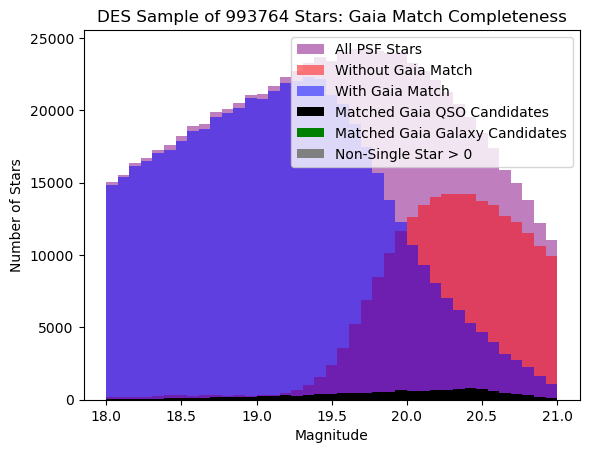

In [35]:
def plot_match_completeness(master_comb_df):
    """
    Plot the magnitude distribution of the matched stars, and the matched stars that are also Gaia QSO and Galaxy candidates.
    Args:
        master_comb_df: Pandas dataframe of matched stars.
    """

    plt.hist(master_comb_df["mag0"], bins = np.linspace(18, 21, 40), label = "All PSF Stars", alpha = 0.5, color = "purple")
    plt.hist(master_comb_df["mag0"][~match_idx], bins = np.linspace(18, 21, 40), label = "Without Gaia Match", alpha = 0.5, color = "red")
    plt.hist(master_comb_df["mag0"][match_idx],bins = np.linspace(18, 21, 40), label = "With Gaia Match", alpha = 0.5, color = "blue")
    plt.hist(master_comb_df["mag0"][match_idx][master_comb_df[match_idx]["in_qso_candidates"] == True], bins = np.linspace(18, 21, 40), label = "Matched Gaia QSO Candidates", color = "black")
    plt.hist(master_comb_df["mag0"][match_idx][master_comb_df[match_idx]["in_galaxy_candidates"] == True], bins = np.linspace(18, 21, 40), label = "Matched Gaia Galaxy Candidates",color = "green")
    plt.hist(master_comb_df["mag0"][match_idx][master_comb_df[match_idx]["non_single_star"] > 0], bins = np.linspace(18, 21, 40), label = "Non-Single Star > 0",color = "grey")
    plt.title(f"DES Sample of {len(master_comb_df)} Stars: Gaia Match Completeness")
    plt.xlabel("Magnitude")
    plt.ylabel("Number of Stars")
    plt.legend()

In [6]:
# Save the dataframe to a csv file
master_comb_df.to_csv("../../psf_data/final_data/zdata/DESY3_Z_MATCHED.csv")

In [1]:
from astropy.io import fits
import pandas as pd
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.vq import vq, kmeans
import scipy
from astroquery.gaia import Gaia
import os

In [4]:
def concatenate_int_data(fold):
    files = os.listdir(fold)
    df_list = []
    for file in files:
        df_list.append(pd.read_csv(fold + file, index_col=0))
        master_comb_df = pd.concat(df_list)
    return master_comb_df

# Load all dataframes in folder and concatenate them
fold = "../../int_data/zdata/"
master_comb_df = concatenate_int_data(fold)

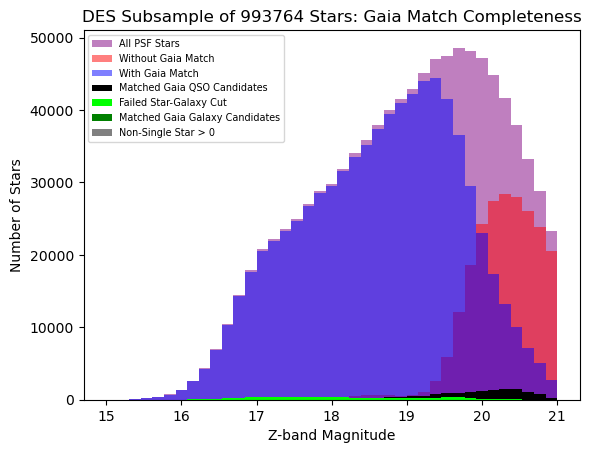

In [5]:
match_idx = (master_comb_df["matched"] == 1)
bounds = [15, 21]
super_match_idx = (master_comb_df[match_idx]["non_single_star"] == 0) & (master_comb_df[match_idx]["in_galaxy_candidates"] == False)
plt.hist(master_comb_df["mag0"], bins = np.linspace(bounds[0], bounds[1], 40), label = "All PSF Stars", alpha = 0.5, color = "purple")
plt.hist(master_comb_df["mag0"][~match_idx], bins = np.linspace(bounds[0], bounds[1], 40), label = "Without Gaia Match", alpha = 0.5, color = "red")
plt.hist(master_comb_df["mag0"][match_idx][super_match_idx],bins = np.linspace(bounds[0], bounds[1], 40), label = "With Gaia Match", alpha = 0.5, color = "blue")
plt.hist(master_comb_df["mag0"][match_idx][master_comb_df[match_idx]["in_qso_candidates"] == True], bins = np.linspace(bounds[0], bounds[1], 40), label = "Matched Gaia QSO Candidates", color = "black")
plt.hist(master_comb_df["mag0"][match_idx][master_comb_df[match_idx]["is_star"] == False], bins = np.linspace(bounds[0], bounds[1], 40), label = "Failed Star-Galaxy Cut", color = "lime")
plt.hist(master_comb_df["mag0"][match_idx][master_comb_df[match_idx]["in_galaxy_candidates"] == True], bins = np.linspace(bounds[0], bounds[1], 40), label = "Matched Gaia Galaxy Candidates",color = "green")
plt.hist(master_comb_df["mag0"][match_idx][master_comb_df[match_idx]["non_single_star"] > 0], bins = np.linspace(bounds[0], bounds[1], 40), label = "Non-Single Star > 0",color = "grey")
plt.title(f"DES Subsample of {len(master_comb_df)} Stars: Gaia Match Completeness")
plt.xlabel("Z-band Magnitude")
plt.ylabel("Number of Stars")
plt.legend(fontsize = "x-small")

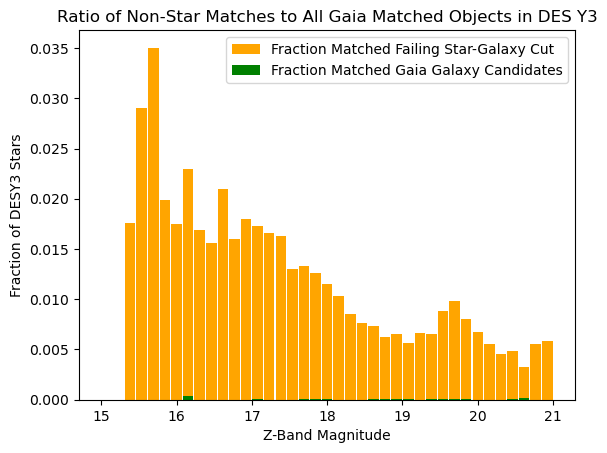

In [21]:
def galaxy_ratio_plot(master_comb_df, bounds = [15, 21], w = 0.1):
    """
    
    """
    # Define the bins
    bins = np.linspace(bounds[0], bounds[1], 40)
    all_match = np.histogram(master_comb_df["mag0"][match_idx], bins = bins)
    galaxy_match = np.histogram(master_comb_df["mag0"][match_idx][master_comb_df[match_idx]["in_galaxy_candidates"] == True], bins = bins)
    failed_star_galaxy_cut = np.histogram(master_comb_df["mag0"][match_idx][master_comb_df[match_idx]["is_star"] == False], bins = bins)

    mid = lambda x: x[:-1] + np.diff(x)/2

    plt.bar(mid(failed_star_galaxy_cut[1]), failed_star_galaxy_cut[0] / all_match[0], label = "Fraction Matched Failing Star-Galaxy Cut",color = "orange", width=0.14)
    plt.bar(mid(galaxy_match[1]), galaxy_match[0] / all_match[0], label = "Fraction Matched Gaia Galaxy Candidates",color = "green", width=0.14)
    plt.title("Ratio of Non-Star Matches to All Gaia Matched Objects")
    plt.xlabel("Z-Band Magnitude")
    plt.ylabel("Fraction of DESY3 Stars")
    plt.legend()
    plt.show()

    plt.bar(mid(failed_star_galaxy_cut[1]), failed_star_galaxy_cut[0] / all_match[0], label = "Fraction Matched Failing Star-Galaxy Cut",color = "orange", width=0.14)
    plt.bar(mid(galaxy_match[1]), galaxy_match[0] / all_match[0], label = "Fraction Matched Gaia Galaxy Candidates",color = "green", width=0.14)
    plt.title("Ratio of Gaia Non-Star Matches to All PSF Stars")
    plt.legend()
    plt.xlabel("Z-Band Magnitude")
    plt.ylabel("Fraction of DESY3 Stars")
    return 

Text(0, 0.5, 'Fraction of DESY3 Stars')

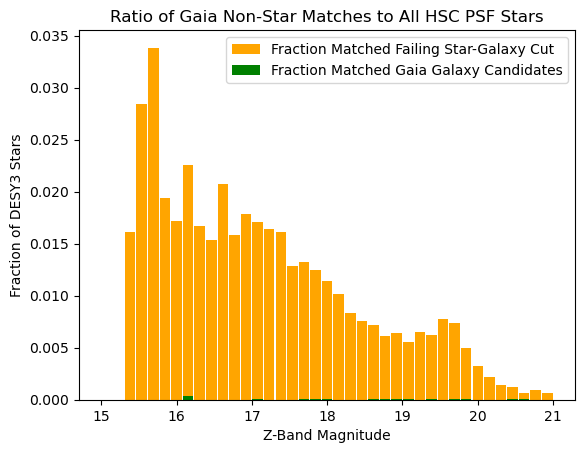

In [22]:
# Make a histogram using np.histogram

# Define the bins
bins = np.linspace(15, 21, 40)
all_match = np.histogram(master_comb_df["mag0"], bins = bins)
galaxy_match = np.histogram(master_comb_df["mag0"][match_idx][master_comb_df[match_idx]["in_galaxy_candidates"] == True], bins = bins)
failed_star_galaxy_cut = np.histogram(master_comb_df["mag0"][match_idx][master_comb_df[match_idx]["is_star"] == False], bins = bins)

mid = lambda x: x[:-1] + np.diff(x)/2

plt.bar(mid(failed_star_galaxy_cut[1]), failed_star_galaxy_cut[0] / all_match[0], label = "Fraction Matched Failing Star-Galaxy Cut",color = "orange", width=0.14)
plt.bar(mid(galaxy_match[1]), galaxy_match[0] / all_match[0], label = "Fraction Matched Gaia Galaxy Candidates",color = "green", width=0.14)
plt.title("Ratio of Gaia Non-Star Matches to All HSC PSF Stars")
plt.legend()
plt.xlabel("Z-Band Magnitude")
plt.ylabel("Fraction of DESY3 Stars")

In [38]:
(master_comb_df[match_idx]["in_galaxy_candidates"]).sum()

21

In [39]:
(master_comb_df[match_idx]["non_single_star"] > 0).sum()

6

In [40]:
(master_comb_df[match_idx]["in_qso_candidates"]).sum()

14135

In [41]:
(~master_comb_df[match_idx]["is_star"]).sum()

7416

In [6]:
comb_df = pd.read_csv("../int_data/DESY3_Cluster_1.csv")


(array([ 12.,  47., 120., 163., 220., 264., 308., 344., 314., 198.]),
 array([15.58727455, 16.12790508, 16.66853561, 17.20916615, 17.74979668,
        18.29042721, 18.83105774, 19.37168827, 19.9123188 , 20.45294933,
        20.99357986]),
 <BarContainer object of 10 artists>)

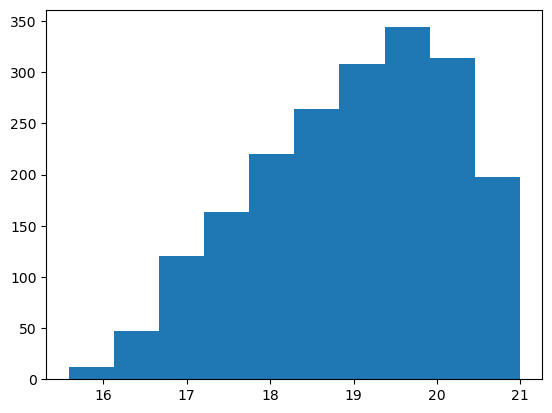

In [9]:
plt.hist(comb_df["mag0"])